IMPORTS

In [74]:
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import time
from datetime import date
import matplotlib.pyplot as plt
from fpdf import FPDF
import os
from tensorflow.keras.models import load_model
import cv2
import json 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D,Flatten,Dropout,MaxPool2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import VGG16,ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

In [75]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

c:\Users\shail\anaconda3\envs\dd\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


PATHS

In [76]:
PATH=''
WORKSPACE_PATH =PATH+ 'Tensorflow/workspace'
SCRIPTS_PATH = PATH+'Tensorflow/scripts'
APIMODEL_PATH = PATH+'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'


CONFIG FILE

In [77]:
with open(ANNOTATION_PATH+'/classes.txt','r') as f:
    classes_=f.readlines()
    classes_=[x.replace('\n','') for x in classes_]
    print(classes_)


['Moonfish', 'Dolphinfish', 'Bigeye tuna']


In [78]:
class config:
    imgWidth=640  ### SET DESIRED IMAGE WIDTH
    imgHeight=640
    input_shape=(imgHeight,imgWidth,3)  ### SET DESIRED IMAGE HEIGHT``
    batchSize=8       ### BATCH SIZE (8,16,32,64)
    epoch=5           ### EPOCH FOR MODEL TRAINING
    classes_=classes_  # TYPE INDIVIDUAL CLASS NAMES HERE 

In [79]:
config.imgHeight,config.imgWidth

(640, 640)

LOADING TRAINING IMAGE DATA

In [81]:
train_images=tf.data.Dataset.list_files(IMAGE_PATH+'/train/*.jpg',shuffle=False)
test_images=tf.data.Dataset.list_files(IMAGE_PATH+'/test/*.jpg',shuffle=False)

def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,
                        (config.imgHeight,config.imgWidth),
                        preserve_aspect_ratio=False,
                        antialias=False,       
    )
    img=tf.cast(
    img, tf.uint8, name=None
    )
    return img
train_images = train_images.map(lambda s : tf.py_function(load_image,[s],tf.uint8))
test_images=test_images.map(lambda s : tf.py_function(load_image,[s],tf.uint8))

ONE HOT ENCODER

In [82]:
### ONE HOT ENCODING FOR LABEL LIST
encoder=OneHotEncoder(sparse=False)
encoder.fit(np.array(config.classes_).reshape(-1,1))

OneHotEncoder(sparse=False)

LOADING LABELS

In [83]:

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        label=dict(label[0])
        label=dict(label['annotations'][0])
        className=label['label']
        classEncoding=encoder.transform([[className]]).reshape(3)
        coordinates=dict(label['coordinates'])
        xmin,ymin,xmax,ymax=coordinates['x'],coordinates['y'],coordinates['width']+coordinates['x'],coordinates['height']+coordinates['y']
        x_scale = config.imgWidth / 1280
        y_scale = config.imgHeight / 720 
        
        xmin,ymin,xmax,ymax=xmin*x_scale,ymin*y_scale,xmax*x_scale,ymax*y_scale
        confidence=1
        if className=="nan":
            confidence=0
            xmin,ymin,xmax,ymax=0
    return np.array(classEncoding),[xmin,ymin,xmax,ymax]
train_labels = tf.data.Dataset.list_files(IMAGE_PATH+'/train/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16, tf.float16]))

test_labels = tf.data.Dataset.list_files(IMAGE_PATH+'/train/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16, tf.float16]))

ANALYSING .JSON FILES

In [84]:
### CHECKING FOR UNWANTED CLASS NAMES
for i in os.listdir('Tensorflow\\workspace\\images\\train\\'):
    if i[-1]=='n':
        with open('Tensorflow\\workspace\\images\\train\\'+i, 'r', encoding = "utf-8") as f:
            label = json.load(f)
            label=dict(label[0])
            label=dict(label['annotations'][0])
            className=label['label']
            print(className)

Moonfish
Bigeye tuna
Dolphinfish
Moonfish
Bigeye tuna
Bigeye tuna
Bigeye tuna
Bigeye tuna
Dolphinfish
Bigeye tuna
Dolphinfish
Dolphinfish
Bigeye tuna
Bigeye tuna
Bigeye tuna
Bigeye tuna
Bigeye tuna
Bigeye tuna
Bigeye tuna
Dolphinfish
Bigeye tuna
Bigeye tuna
Bigeye tuna
Dolphinfish
Moonfish
Dolphinfish
Dolphinfish
Bigeye tuna
Dolphinfish
Dolphinfish
Dolphinfish
Bigeye tuna
Bigeye tuna
Moonfish
Bigeye tuna
Bigeye tuna
Dolphinfish
Bigeye tuna
Dolphinfish
Dolphinfish
Bigeye tuna
Bigeye tuna
Moonfish
Dolphinfish
Dolphinfish
Bigeye tuna
Dolphinfish
Bigeye tuna
Dolphinfish
Bigeye tuna
Bigeye tuna
Bigeye tuna
Dolphinfish
Bigeye tuna
Bigeye tuna
Bigeye tuna
Dolphinfish
Bigeye tuna
Bigeye tuna
Bigeye tuna
Dolphinfish
Dolphinfish
Bigeye tuna
Bigeye tuna
Moonfish
Dolphinfish
Dolphinfish
Dolphinfish
Bigeye tuna
Bigeye tuna
Moonfish
Moonfish
Dolphinfish
Dolphinfish
Dolphinfish
Dolphinfish
Dolphinfish
Moonfish
Bigeye tuna
Bigeye tuna
Bigeye tuna
Bigeye tuna
Moonfish
Dolphinfish
Dolphinfish
Dolphinfis

COMBING IMAGES AND LABELS

In [85]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(config.batchSize)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(config.batchSize)
test = test.prefetch(4)


In [86]:
train.as_numpy_iterator().next()[1]

(array([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]], dtype=float16),
 array([[167.1, 456.5, 268. , 848.5],
        [420.8, 290.5, 595. , 589. ],
        [309.8, 668. , 479.2, 887.5],
        [394.2, 375.8, 496.8, 507.5],
        [332.5, 185.1, 486.5, 264.2],
        [297.2, 762. , 594. , 923.5],
        [387.8, 373.5, 479.2, 509.5],
        [329.8, 124.4, 443.2, 373. ]], dtype=float16))

DOWNLOAD VGG16 MODEL

In [13]:
resnet=ResNet50V2(include_top=True)

In [14]:
vgg = VGG16(weights='imagenet',include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

BUILDING AN INSTANCE OF MODEL

In [15]:
def build_model(): 
    input_layer = Input(shape=(config.imgHeight,config.imgWidth,3))
    
    vgg = VGG16(weights='imagenet',include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(len(config.classes_), activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    model = Model(inputs=input_layer, outputs=[class2, regress2])
    return model



In [16]:
fishtracker = build_model()
fishtracker.summary()
X, y = train.as_numpy_iterator().next()
classes, coords = fishtracker.predict(X)
classes, coords


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_3[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

(array([[6.4088054e-24, 9.9889177e-01, 1.0000000e+00],
        [1.1143667e-33, 2.5564614e-10, 8.7100631e-01],
        [4.8287207e-29, 1.0809930e-02, 8.5008609e-01],
        [1.6519819e-23, 3.4965417e-01, 1.0000000e+00],
        [1.2683405e-37, 1.4489337e-06, 1.0000000e+00],
        [9.6726340e-26, 1.0708549e-10, 9.9569583e-01],
        [1.8746444e-28, 1.4565632e-07, 1.0000000e+00],
        [0.0000000e+00, 8.2128467e-03, 3.0279567e-02]], dtype=float32),
 array([[1.0000000e+00, 1.6185088e-02, 1.4178504e-34, 1.0000000e+00],
        [9.9999881e-01, 7.3934007e-01, 3.6591032e-23, 1.0000000e+00],
        [1.0000000e+00, 9.5194197e-01, 3.3781516e-27, 1.0000000e+00],
        [1.0000000e+00, 9.9919838e-01, 5.6550405e-31, 1.0000000e+00],
        [6.3025905e-06, 7.1726083e-09, 1.0381175e-26, 1.0000000e+00],
        [8.7354094e-02, 9.9999630e-01, 1.8141770e-20, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 5.8493424e-18, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 4.7328696e-29,

TEST OUT NEURAL NETWORK

DEFINING LOSSES AND OPTIMIZERS

In [17]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

CREATE LOCALIZATION LOSS AND CLASSIFICATION LOSS

In [19]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [20]:
classloss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
regressloss = tfa.losses.GIoULoss()

TESTING LOSS METRICS

In [21]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2431680.0>

In [22]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.85818887>

In [23]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8517244>

CREATING CUSTOM MODEL CLASS

In [24]:
class FishTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker


    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [25]:
model = FishTracker(fishtracker)
model.compile(opt, classloss, regressloss)


# TRANING MODEL

In [26]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
hist = model.fit(train, epochs=4,callbacks=callback)

Epoch 1/4
48/48 [==============================] - 53s 870ms/step - loss: 2.2360 - class_loss: 0.6956 - regress_loss: 1.8882
Epoch 2/4
48/48 [==============================] - 40s 735ms/step - loss: 2.2323 - class_loss: 0.6931 - regress_loss: 1.8857
Epoch 3/4
48/48 [==============================] - 40s 737ms/step - loss: 2.2363 - class_loss: 0.6931 - regress_loss: 1.8898
Epoch 4/4
48/48 [==============================] - 40s 740ms/step - loss: 2.2357 - class_loss: 0.6931 - regress_loss: 1.8892


# SAVE MODEL

In [27]:
fishtracker.save(MODEL_PATH+'/linear_mse/')

INFO:tensorflow:Assets written to: Tensorflow/workspace/models/linear_mse/assets


# LOAD MODEL

In [62]:
fishtracker= load_model(MODEL_PATH+'/linear_mse/')

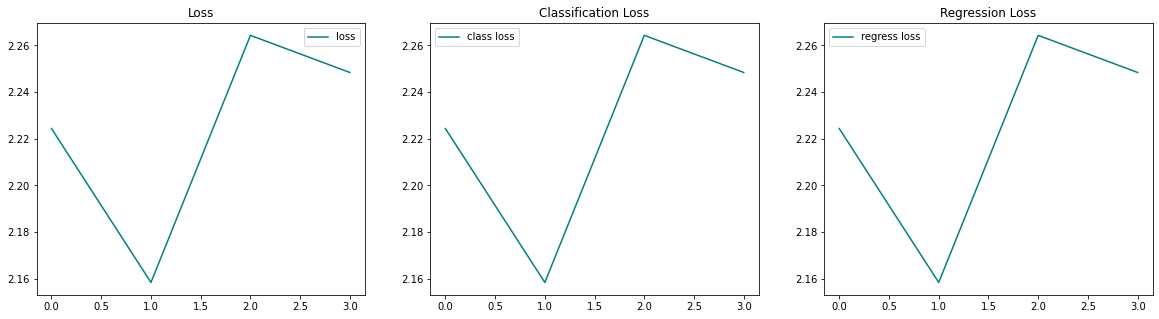

In [29]:
hist.history
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['loss'], color='teal', label='class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['loss'], color='teal', label='regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


img_00435
['img_00435.jpg']


[]

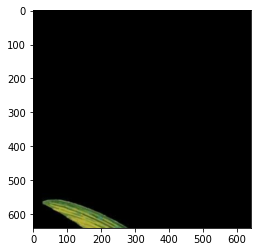

In [87]:

path=os.listdir(IMAGE_PATH+'/test/')
fin_path=[]

for i in path:
    if i[-1] != 'n':
        fin_path.append(i)
new_dir=fin_path[0].split('.')[0]
print(new_dir)
if os.path.exists(IMAGE_PATH+'/test/'+new_dir) == False:
    os.mkdir(IMAGE_PATH+'/test/'+new_dir)
print(fin_path)



import image_slicer
tiles = image_slicer.slice(IMAGE_PATH+'/test/'+ fin_path[0], 10, save=False)
image_slicer.save_tiles(tiles, directory=IMAGE_PATH+'/test/'+new_dir,prefix='slice', format='jpeg')

test_images_path=tf.data.Dataset.list_files(IMAGE_PATH+'/test/{}/*.jpg'.format(new_dir),shuffle=False)

def load_test_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,
                        (config.imgHeight,config.imgWidth),
                        preserve_aspect_ratio=False,
                        antialias=False,       
    )
    img=tf.cast(
    img, tf.uint8, name=None
    )
    return img

test_images=test_images_path.map(lambda s : tf.py_function(load_test_image,[s],tf.uint8))
plt.imshow(test_images.as_numpy_iterator().next())
plt.plot()



[[1.         1.         0.         0.01956802]] [[0.0000000e+00 8.1986105e-32 0.0000000e+00]]
[array([[0.0000000e+00, 8.1986105e-32, 0.0000000e+00]], dtype=float32), array([[1.        , 1.        , 0.        , 0.01956802]], dtype=float32)]
[[1.000000e+00 1.000000e+00 4.439166e-16 2.883985e-04]] [[0.0000000e+00 1.8267426e-13 0.0000000e+00]]
[array([[0.0000000e+00, 1.8267426e-13, 0.0000000e+00]], dtype=float32), array([[1.000000e+00, 1.000000e+00, 4.439166e-16, 2.883985e-04]],
      dtype=float32)]
[[1.00000000e+00 1.00000000e+00 2.38982257e-31 1.09283194e-10]] [[0.0000000e+00 3.5492872e-22 0.0000000e+00]]
[array([[0.0000000e+00, 3.5492872e-22, 0.0000000e+00]], dtype=float32), array([[1.00000000e+00, 1.00000000e+00, 2.38982257e-31, 1.09283194e-10]],
      dtype=float32)]
[[1.0000000e+00 1.0000000e+00 2.5187723e-36 8.4816187e-15]] [[0.000000e+00 4.581898e-31 0.000000e+00]]
[array([[0.000000e+00, 4.581898e-31, 0.000000e+00]], dtype=float32), array([[1.0000000e+00, 1.0000000e+00, 2.5187723e

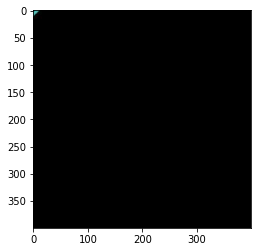

In [88]:

boxlist=[]
classConfidence=[]
color=[(0,0,0),(0,255,255),(0,0,255)]


for i in os.listdir(IMAGE_PATH+'/test/'+new_dir):
    image=cv2.imread(IMAGE_PATH+'/test/'+new_dir+'/'+i)
    img=tf.image.resize(image,
                        (config.imgHeight,config.imgWidth),
                        preserve_aspect_ratio=False,
                        antialias=False,       
    )
    img=tf.cast(
    img, tf.uint8, name=None
    )
    prediction=model.predict(np.expand_dims(img,axis=0))
    xmin,ymin,xmax,ymax=[round(x) for x in (prediction[1]).reshape(4)]
    boxlist.append([xmin,ymin,xmax,ymax])
    classConfidence.append(prediction[0])
    print(prediction[1],prediction[0])
    plt.imshow(image)
    plt.plot()
    print(prediction)

In [89]:
boxlist

[[1, 1, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 1],
 [1, 1, 0, 1],
 [1, 1, 0, 0],
 [1, 1, 0, 1]]

In [90]:
prediction

[array([[0.000000e+00, 6.897686e-09, 0.000000e+00]], dtype=float32),
 array([[1.0000000e+00, 1.0000000e+00, 1.8035286e-14, 9.9998558e-01]],
       dtype=float32)]

In [91]:
'''%matplotlib inline 
image=test.as_numpy_iterator().next()[0].copy()
plt.imshow(np.squeeze(image))
plt.plot()
boxlist=[]
classConfidence=[]
color=[(0,0,0),(0,255,255),(0,0,255)]


for i in range(10):
    prediction=model.predict(image)
    xmin,ymin,xmax,ymax=[round(x) for x in (prediction[1]).reshape(4)]
    boxlist.append([xmin,ymin,xmax,ymax])
    classConfidence.append(prediction[0])
    print(prediction[1],prediction[0])
    image=cv2.rectangle(np.squeeze(image), (xmin,ymin), (xmax,ymax), (0,0,0),-1)
    plt.imshow(image)
    plt.plot()
    image=np.expand_dims(image, axis=0)
'''

'%matplotlib inline \nimage=test.as_numpy_iterator().next()[0].copy()\nplt.imshow(np.squeeze(image))\nplt.plot()\nboxlist=[]\nclassConfidence=[]\ncolor=[(0,0,0),(0,255,255),(0,0,255)]\n\n\nfor i in range(10):\n    prediction=model.predict(image)\n    xmin,ymin,xmax,ymax=[round(x) for x in (prediction[1]).reshape(4)]\n    boxlist.append([xmin,ymin,xmax,ymax])\n    classConfidence.append(prediction[0])\n    print(prediction[1],prediction[0])\n    image=cv2.rectangle(np.squeeze(image), (xmin,ymin), (xmax,ymax), (0,0,0),-1)\n    plt.imshow(image)\n    plt.plot()\n    image=np.expand_dims(image, axis=0)\n'

In [92]:
classConfidence=[np.squeeze(x) for x in classConfidence]
classConfidence

[array([0.0000000e+00, 8.1986105e-32, 0.0000000e+00], dtype=float32),
 array([0.0000000e+00, 1.8267426e-13, 0.0000000e+00], dtype=float32),
 array([0.0000000e+00, 3.5492872e-22, 0.0000000e+00], dtype=float32),
 array([0.000000e+00, 4.581898e-31, 0.000000e+00], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0.04604136, 0.5397251 , 0.07297484], dtype=float32),
 array([0.04604136, 0.5397251 , 0.07297484], dtype=float32),
 array([0.000000e+00, 1.998319e-23, 0.000000e+00], dtype=float32),
 array([0.000000e+00, 6.897686e-09, 0.000000e+00], dtype=float32)]

In [93]:
classEncoded = np.zeros_like(classConfidence)
check=[x.argmax() for x in classConfidence]
print(check)
for i in range(len(check)):
    classEncoded[i][check[i]]=1

classEncoded

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [94]:
classMax=[max(x) for x in np.squeeze(classConfidence)]
boxIndex=tf.image.non_max_suppression(boxlist,classMax,max_output_size=50,iou_threshold=0.1)
boxIndex

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 8,  9, 11,  1])>

In [95]:
boxList_=[]
for i in boxIndex:
    boxList_.append(boxlist[i])
boxList_

[[1, 1, 0, 1], [1, 1, 0, 1], [1, 1, 0, 1], [1, 1, 0, 0]]

In [96]:
classPrediction=encoder.inverse_transform(classEncoded)
classPrediction

array([['Dolphinfish'],
       ['Dolphinfish'],
       ['Dolphinfish'],
       ['Dolphinfish'],
       ['Bigeye tuna'],
       ['Bigeye tuna'],
       ['Bigeye tuna'],
       ['Bigeye tuna'],
       ['Dolphinfish'],
       ['Dolphinfish'],
       ['Dolphinfish'],
       ['Dolphinfish']], dtype='<U11')

[0.00000e+00 2.69064e-25 0.00000e+00] Dolphinfish [1, 1, 0, 0]


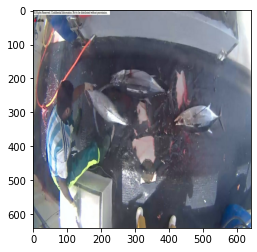

In [41]:
main_image=test.as_numpy_iterator().next()[0]
image=np.squeeze(main_image.copy())
for i in boxIndex:
    xmin,ymin,xmin,xmax=boxlist[i]
    print(classConfidence[i],classPrediction[np.array(boxIndex)][0][0],boxlist[i])
    image=cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,0,0),2)
    plt.imshow(image)
    plt.plot()

In [97]:
def speciesCount(boundingList):
    count={}
    fl=0
    for j in config.classes_:
        count[j]=0
    for i in range(len(boundingList)):
        print(boxList_[i],classPrediction[i][0])
        temp=list(classPrediction[i])[0]
        count[temp]=count[temp]+1
    print(count)
    return count



speciesCount_=speciesCount(boundingList=boxList_)

[1, 1, 0, 1] Dolphinfish
[1, 1, 0, 1] Dolphinfish
[1, 1, 0, 1] Dolphinfish
[1, 1, 0, 0] Dolphinfish
{'Moonfish': 0, 'Dolphinfish': 4, 'Bigeye tuna': 0}


In [98]:
biomassData={
    'Moonfish':2,
    'Dolphinfish':4,
    'Bigeye tuna':6,
}

In [99]:
bioMass={}
for i,j in speciesCount_.items():
    bioMass[i]=biomassData[i]*j

bioMass

{'Moonfish': 0, 'Dolphinfish': 16, 'Bigeye tuna': 0}

# GENERATE REPORT

In [100]:
from datetime import datetime

def create_report(speciesList):
    out_str=[]
    for species,count in speciesList.items():
        out_str.append(' '.join([species,':',str(count)]))
        #print(species,count)
        #out_str
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)
    pdf.cell(190, 15, 'Total Species Count And Biomass', 1, 0, 'C')
    pdf.ln(30)

    pdf.cell(40, 10,'Name : VINOTH KUMAR')
    pdf.ln()

    pdf.cell(40, 10,'Id   : FR204187')
    pdf.ln()

    pdf.cell(40, 10,'Age  : 36')
    pdf.ln()

    pdf.cell(40, 10,'Time : '+str(datetime.now()))
    pdf.ln(15)

    pdf.cell(0,0,'-----------------------------------------------------------------------------------------------------')
    pdf.ln(10)
    for species in out_str:
        pdf.cell(40, 10,species)
        pdf.ln()
    pdf.output('final_report.pdf', 'F')
    print("Report Created Successfully")


In [101]:
create_report(speciesList=speciesCount_)

Report Created Successfully


# MAIL AND SMS FILES

SMS

In [102]:
from twilio.rest import Client

account_sid='AC1c898986e90251c293f2612e47aa8a25'
auth_token='759966e5d33ed91feed43ca1294c757e'
client = Client(account_sid, auth_token)

twilio_number='+19705145914'
target_number='+917010903976'


for species,count in speciesCount_.items():
    if species=='Dolphinfish' and count>0:
        message =client.messages.create(
        body="ALERT!!!--Dolphinfish caught",
        from_=twilio_number,
        to=target_number
        )

        print(message.body)



Sent from your Twilio trial account - ALERT!!!--Dolphinfish caught


In [103]:
# Importing required library
import pygsheets

# Create the Client
client = pygsheets.authorize(service_account_file="sih2022-360518-69683d9cb0a2.json")

# opens a spreadsheet by its name/title
spreadsht = client.open("sih")

# opens a worksheet by its name/title
worksht = spreadsht.worksheet("title", "Sheet1")

# Now, let's add data to our worksheet

# Creating the first column
worksht.cell("A1").set_text_format("bold", True).value = "S.NO"
worksht.update_values("A2:A3", [[1],[2]]) # Adding row values


worksht.cell("B1").set_text_format("bold", True).value = "Species"
worksht.update_values("B2:B3", [['Bigeye tuna'],['Dolphinfish']]) # Adding row values

# Similarly, creating the second column
worksht.cell("C1").set_text_format("bold", True).value = "Count"
worksht.update_values("C2:C3", [[speciesCount_['Bigeye tuna']], [speciesCount_['Dolphinfish']]])

# Similarly, creating the second column
worksht.cell("D1").set_text_format("bold", True).value = "Biomass(Kg)"
worksht.update_values("D2:D3", [[bioMass['Bigeye tuna']], [bioMass['Dolphinfish']]])
# Creating a basic bar chart
worksht.add_chart(("B2", "B6"), [("C2", "C6")], "Fish")



<Chart COLUMN 'Fish'>